In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
import time
%matplotlib inline

## Applying the model

Let's try $k$-means on some [heart disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.  Our goal will be to create a $k$-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
# Define the features and the outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

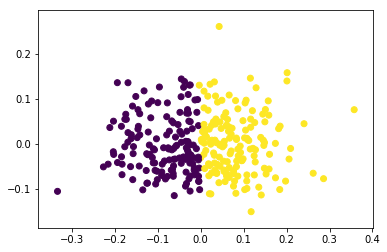

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99
Time: 0.25437378883361816
Score:  0.391030186315


In [5]:
t0 = time.time()

# Normalize the data.
X_norm = normalize(X)

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

t1 = time.time()
print('Time:',t1-t0)

# Score
score = silhouette_score(X_pca, y_pred)

print('Score: ', score)

Looks like this model isn't doing very well. We're correctly classifying 182 cases, but mis-classifying 120 of the cases!

Now let's try MiniBatch:

Comparing k-means and mini batch k-means solutions:
col_0    0    1
row_0          
0        0  151
1      149    3


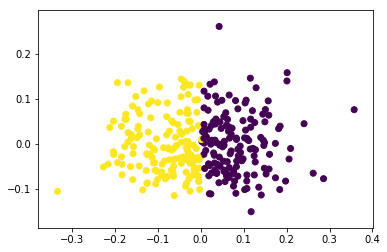

Time: 0.19514083862304688
Score:  0.390690408356


In [6]:
t0 = time.time()

#Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predict_mini)
plt.show()

t1 = time.time()
print('Time:',t1-t0)

# Score
score = silhouette_score(X_pca, predict_mini)

print('Score: ', score)

This marks a significant change. How substantial is the computational performance improvement? Try re-running the $k$-means and mini batch $k$-means models and timing their execution. Check out the [%timeit magic](https://ipython.org/ipython-doc/3/interactive/magics.html#magic-timeit) for helpful timing tools.

## Drill: More clusters?

Your task is to take the $k$-means code here and see what happens when you change the value of $k$.  What solution, if any, do you find most compelling? Does complexity start to become an issue with this data set? Play around a bit and write up your findings and your process to share with your mentor.  Keep in mind that it may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

In [7]:
t0 = time.time()

# Each batch will be made up of 200 data points.

mbkmeans = MiniBatchKMeans()
hyperparams = {
    'n_clusters': [2, 3, 4, 10, 20, 40],
    'init':['random'],
    'max_iter':[100,200,300,400,500],
    'tol':[1e-6, 1e-4, 1e-2],
    'batch_size':[100,200, 300]
}

grid_mbkmeans = GridSearchCV(
    estimator=mbkmeans,
    param_grid=hyperparams,
    n_jobs=1)

grid_mbkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.

predict_mini = grid_mbkmeans.predict(X_pca)
score = silhouette_score(X_pca, predict_mini)

print(score)
print(grid_mbkmeans.best_params_)

t1 = time.time()
print('Time:',t1-t0)

0.275133413237
{'batch_size': 200, 'init': 'random', 'max_iter': 300, 'n_clusters': 40, 'tol': 1e-06}
Time: 13.598264932632446


In [8]:
# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y))

Comparing k-means and mini batch k-means solutions:
col_0  0   1
row_0       
0      2   7
1      3   1
2      7   0
3      4   8
4      1   4
5      3   4
6      2   4
7      6  11
8      7   2
9      2   6
10     6   5
11     0   4
12     6   3
13     3   2
14     3  11
15     5   8
16     4   0
17     3   0
18     6   0
19     2   0
20     4   3
21     1   2
22     3   1
23     1   4
24     5   3
25     1   2
26     6   2
27     3   8
28     0   5
29     1   5
30     5  19
31     9   1
32     4   3
33     2   5
34     4   5
35     2   6
36     4   2
37     6   3
38     3   3
39     0   2


### Conclusions

From the sklearn library we can get to the following assumption regarding the silhouette score: 

_"The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar."_

So, we run a GridSearchCV code that determined the best values for the MiniBatchKmeans in theory. However, the score for those parameters (40 clusters), was 0.27, whereas whith the original parameters it was 0.39. These results could indicate that though the parameters from GridSearchCV were the most optimal, they are closer to overfit, so we should explore new ways to increase the silhouette score to 1.